# Assignment 3

# F1 dataset

Skipping non-image file: /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000291.215855
Skipping /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000374.png: Image shape is not valid.
Skipping non-image file: /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000033.180946
Skipping /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000462.png: Image shape is not valid.
Skipping non-image file: /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000087.ashx
Skipping non-image file: /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000475.php
Skipping non-image file: /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000265.293783
Skipping non-image file: /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000243.236165
Skipping non-image file: /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000518.272105
Skipping /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000444.png: Image shape is not valid.
Skipping non-image file: /Users/ananyamudunuri/Desktop/Ferrari F1 car/00000043.php
Skipping /Users/ananyamudunuri/Desktop

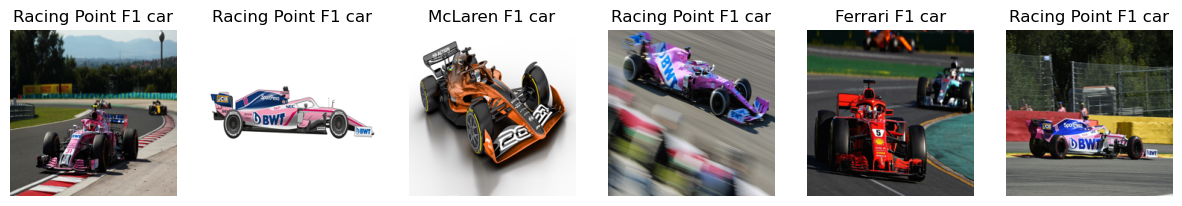

In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.utils import shuffle

# Define paths to your folders on the desktop
data_dir = '/Users/ananyamudunuri/Desktop/'
categories = ['Ferrari F1 car', 'Racing Point F1 car', 'McLaren F1 car']

# Initialize lists to hold images and labels
images = []
labels = []

# Define valid image formats
valid_image_formats = ('.jpg', '.jpeg', '.png')

# Loop through each category folder, load images, and assign labels
for idx, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        if img_name.lower().endswith(valid_image_formats):
            try:
                img = Image.open(img_path).resize((224, 224))  # Resize images
                img = np.array(img)
                if img.shape == (224, 224, 3):  # Ensure uniform shape (RGB)
                    images.append(img)
                    labels.append(idx)  # Assign label based on category index
                else:
                    print(f"Skipping {img_path}: Image shape is not valid.")
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        else:
            print(f"Skipping non-image file: {img_path}")

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Shuffle images and labels together
X, y = shuffle(X, y, random_state=42)

# Normalize images by scaling pixel values to [0, 1]
X = X / 255.0
print("Image loading, shuffling, and preprocessing completed.")

import matplotlib.pyplot as plt

def display_sample_images(X, y, categories, num_images=6):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axs[i].imshow(X[i])
        axs[i].set_title(categories[y[i]])  # Display the label based on index
        axs[i].axis('off')
    plt.show()

# Call the function to display shuffled images
display_sample_images(X, y, categories)

# Split the data: 80% training and 20% test

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data splitting completed.")
print(f"Training set size: {X_train.shape[0]} images")
print(f"Test set size: {X_test.shape[0]} images")

Data splitting completed.
Training set size: 787 images
Test set size: 197 images


# Data preprocessing

In [3]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

# Define transformations (you can add augmentations here)
train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize to match ImageNet pretrained models
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Apply transformations and create TensorDataset
X_train_tensor = torch.tensor(X_train.transpose((0, 3, 1, 2)), dtype=torch.float32)  # Channels first for PyTorch
X_test_tensor = torch.tensor(X_test.transpose((0, 3, 1, 2)), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data preprocessing and loading completed.")

Data preprocessing and loading completed.


# Create a Convolutional Neural Network (CNN)


In [4]:
import torch.nn as nn
import torch.optim as optim

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, len(categories))  # Output: Number of categories (3 in your case)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten the output
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
cnn_model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

print("CNN model created.")

CNN model created.


# Train the CNN Model

In [5]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

train_model(cnn_model, train_loader, criterion, optimizer)

Epoch 1/10, Loss: 1.4369172978401183
Epoch 2/10, Loss: 0.669751662015915
Epoch 3/10, Loss: 0.4626136791706085
Epoch 4/10, Loss: 0.2514929622411728
Epoch 5/10, Loss: 0.1409850036725402
Epoch 6/10, Loss: 0.07127317178994418
Epoch 7/10, Loss: 0.040389539450407026
Epoch 8/10, Loss: 0.020667279502376915
Epoch 9/10, Loss: 0.022353303674608468
Epoch 10/10, Loss: 0.02188192052766681


# Evaluate the CNN Model

In [6]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total}%")

# Evaluate the trained model
evaluate_model(cnn_model, test_loader)

Test Accuracy: 84.77157360406092%


# CNN Predictions:

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

def make_predictions(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Make predictions with CNN model
cnn_predictions, cnn_true_labels = make_predictions(cnn_model, test_loader)

In [8]:
# Calculate accuracy
cnn_accuracy = accuracy_score(cnn_true_labels, cnn_predictions)
print(f"CNN Model Test Accuracy: {cnn_accuracy * 100:.2f}%")

# Display confusion matrix
print("Confusion Matrix for CNN Model:")
print(confusion_matrix(cnn_true_labels, cnn_predictions))

# Display detailed classification report
print("Classification Report for CNN Model:")
print(classification_report(cnn_true_labels, cnn_predictions, target_names=categories))

CNN Model Test Accuracy: 84.77%
Confusion Matrix for CNN Model:
[[56  1 14]
 [ 3 47  3]
 [ 3  6 64]]
Classification Report for CNN Model:
                     precision    recall  f1-score   support

     Ferrari F1 car       0.90      0.79      0.84        71
Racing Point F1 car       0.87      0.89      0.88        53
     McLaren F1 car       0.79      0.88      0.83        73

           accuracy                           0.85       197
          macro avg       0.85      0.85      0.85       197
       weighted avg       0.85      0.85      0.85       197



# Make predictions on the test data and compare them to the expected categories



Test Accuracy: 84.77%


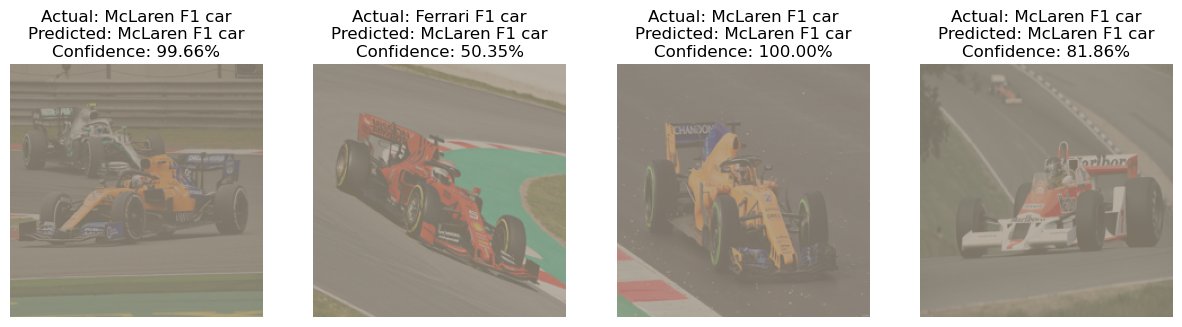

In [9]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_and_show_images(model, test_loader, categories, num_images=4):
    model.eval()
    all_predictions = []
    all_labels = []
    all_confidences = []
    all_images = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_labels = torch.argmax(probabilities, dim=1)
            confidences = torch.max(probabilities, dim=1).values
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            all_images.extend(images.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        img = all_images[i].transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        actual_label = categories[all_labels[i]]
        predicted_label = categories[all_predictions[i]]
        confidence = all_confidences[i]
        
        axs[i].imshow(img)
        axs[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence * 100:.2f}%")
        axs[i].axis('off')
    
    plt.show()

evaluate_model_and_show_images(cnn_model, test_loader, categories, num_images=4)

# Use GoogleNet (InceptionNet) with Linear Layer

In [12]:
from torchvision import models

# Load pre-trained GoogleNet
googlenet = models.googlenet(pretrained=True)

# Replace the final layer to fit the number of classes (3)
googlenet.fc = nn.Linear(googlenet.fc.in_features, len(categories))

# Define optimizer and loss function
googlenet_optimizer = optim.Adam(googlenet.parameters(), lr=0.001)

# Train GoogleNet in the same way as CNN
train_model(googlenet, train_loader, criterion, googlenet_optimizer)

/Users/ananyamudunuri/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ananyamudunuri/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.38462831974029543
Epoch 2/10, Loss: 0.14993724036961795
Epoch 3/10, Loss: 0.06565536055713891
Epoch 4/10, Loss: 0.0703761150687933
Epoch 5/10, Loss: 0.058885191883891824
Epoch 6/10, Loss: 0.11599510388448835
Epoch 7/10, Loss: 0.05245990050956607
Epoch 8/10, Loss: 0.05737112946342677
Epoch 9/10, Loss: 0.04986344718839973
Epoch 10/10, Loss: 0.04008707516826689


# Compare Accuracy of GoogleNet and CNN


In [13]:
# Evaluate the GoogleNet model
evaluate_model(googlenet, test_loader)

Test Accuracy: 90.86294416243655%
